# <b>

<p>
<center>
<font size="5">
Home Credit Default Risk
</font>
</center>
</p>

<p>
<center>
<font size="4">
-Can you predict how capable each applicant is of repaying a loan?
</font>
</center>
</p>

<p>
<center>
<font size="3">
Author: Kang Huang, Xinyu Yao, Ya liu
</font>
</center>
</p>

</b>

# Introduction 
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're in need of help unlocking the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Experiment 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [18]:
import pandas as pd

# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
print(app_train.head())

# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
print(app_test.head())

Training data shape:  (307511, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0

## Pre-processing

### Check anomalous values

In [19]:
print((app_train['DAYS_BIRTH'] / 365).describe())

count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64


'DAYS_BIRTH' are negative values which does not make sense, so we get their absolute values.

In [20]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

In [5]:
print(app_train['DAYS_EMPLOYED'].describe())

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


'DAYS_EMPLOYED' is How many days before the application the person started current employment. The maximum value 365243 (besides being positive) is about 1000 years.

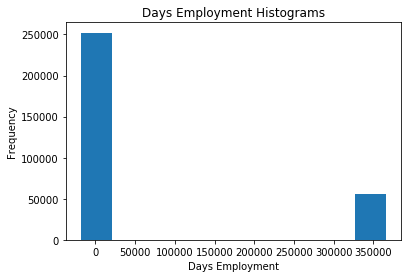

There are 18.01% anomalies in the train data
There are 19.03% anomalies in the test data


In [6]:
plt.hist(app_train['DAYS_EMPLOYED'].values)
plt.title('Days Employment Histograms')
plt.xlabel('Days Employment')
plt.ylabel('Frequency')
plt.show()

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] > 36500
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] > 36500

print('There are %0.2f%% anomalies in the train data' % (100 * app_train["DAYS_EMPLOYED_ANOM"].sum()/len(app_train)))
print('There are %0.2f%% anomalies in the test data' % (100 * app_test["DAYS_EMPLOYED_ANOM"].sum()/len(app_test)))

There're about 20%, so before we replace these anomalous values with nan, we create a new column to set a flag of these originally anomalous values and then we replace these anomalous values with nan. Also we transfer 'DAYS_EMPLOYED' to their absolute values to make it non-negative.

In [21]:
# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

app_test['DAYS_EMPLOYED'] = abs(app_test['DAYS_EMPLOYED'])
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

We then check the distribution of 'DAYS_EMPLOYED'.

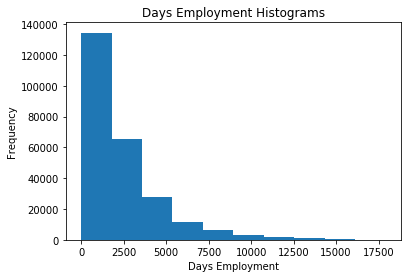

In [22]:
plt.hist(app_train['DAYS_EMPLOYED'].values)
plt.title('Days Employment Histograms')
plt.xlabel('Days Employment')
plt.ylabel('Frequency')
plt.show()

The distribution looks to be much more in line with what we would expect.

### Check missing values

In [23]:
# Function to calculate missing values by column# Funct
def missing_value_checker(df):
    """
    The missing value checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The variables with missing value and their proportion of missing value
    """
    
    variable_proportion = [[variable, df[variable].isna().sum() / df.shape[0]] 
                           for variable in df.columns 
                           if df[variable].isna().sum() > 0]

    print('%-30s' % 'Variable with missing values', 'Proportion of missing values')
    for variable, proportion in sorted(variable_proportion, key=lambda x : x[1]):
        print('%-30s' % variable, proportion)
        
    return variable_proportion
# Missing values statistics
print(missing_value_checker(app_train))
print(missing_value_checker(app_test))

Variable with missing values   Proportion of missing values
DAYS_LAST_PHONE_CHANGE         3.2519161916159095e-06
CNT_FAM_MEMBERS                6.503832383231819e-06
AMT_ANNUITY                    3.9022994299390916e-05
AMT_GOODS_PRICE                0.0009040327012692228
EXT_SOURCE_2                   0.0021462646864665006
OBS_30_CNT_SOCIAL_CIRCLE       0.0033202064316398437
DEF_30_CNT_SOCIAL_CIRCLE       0.0033202064316398437
OBS_60_CNT_SOCIAL_CIRCLE       0.0033202064316398437
DEF_60_CNT_SOCIAL_CIRCLE       0.0033202064316398437
NAME_TYPE_SUITE                0.004201475719567756
AMT_REQ_CREDIT_BUREAU_HOUR     0.13501630835970097
AMT_REQ_CREDIT_BUREAU_DAY      0.13501630835970097
AMT_REQ_CREDIT_BUREAU_WEEK     0.13501630835970097
AMT_REQ_CREDIT_BUREAU_MON      0.13501630835970097
AMT_REQ_CREDIT_BUREAU_QRT      0.13501630835970097
AMT_REQ_CREDIT_BUREAU_YEAR     0.13501630835970097
DAYS_EMPLOYED                  0.18007160719453938
EXT_SOURCE_3                   0.19825307062186392
O

### Remove irrelevant features and impute missing values

In [24]:
for df in [app_train,app_test]:
    for col in ['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
                'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG',
                'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI', 'LANDAREA_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE',
                'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_HOUR',
                'AMT_REQ_CREDIT_BUREAU_YEAR', 'TOTALAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'NONLIVINGAREA_MODE',
                'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_AVG', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI', 'APARTMENTS_MODE', 'APARTMENTS_MEDI',
                'APARTMENTS_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'LIVINGAREA_AVG',
                'FLOORSMAX_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMAX_MEDI', 'DAYS_EMPLOYED']:
        df[col].fillna(0, inplace=True)
    df.drop(['NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE'],axis=1, inplace=True)
    df['OCCUPATION_TYPE'].fillna('unemployed', inplace=True)
    df['EMERGENCYSTATE_MODE'].fillna('No', inplace=True)
    df['NAME_CONTRACT_TYPE'].fillna('Cash loans', inplace=True)

app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

target = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

columns = list(app_train.columns)

from sklearn.preprocessing import Imputer
import numpy as np

si = Imputer(missing_values=np.nan, strategy='median')

app_train = si.fit_transform(app_train)
app_test = si.transform(app_test)
                        
app_train = pd.DataFrame(app_train, columns=columns)
app_test = pd.DataFrame(app_test, columns=columns)

# Add the target back in
app_train['TARGET'] = target

print(missing_value_checker(app_train))
print(missing_value_checker(app_test))

Variable with missing values   Proportion of missing values
[]
Variable with missing values   Proportion of missing values
[]


## EDA

### Distribution of target

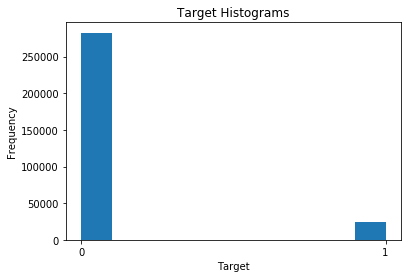

In [51]:
plt.hist(app_train['TARGET'].values)
plt.title('Target Histograms')
plt.xticks(np.arange(0, 1.1, step=1))
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

Imbalanced data set.
There are far more loans that were repaid on time than loans that were not repaid.

### Effect of age on target (applicant has difficulty repay the loan or not)

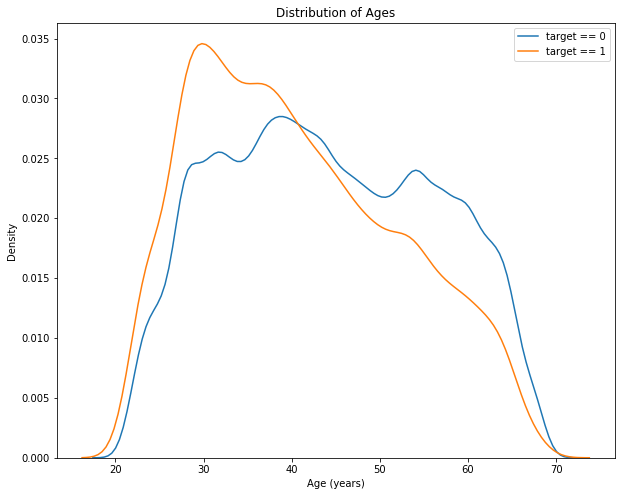

In [25]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.show()

The target == 1 (applicant has difficulty repay the loan) curve skews towards the younger end of the range. 

Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

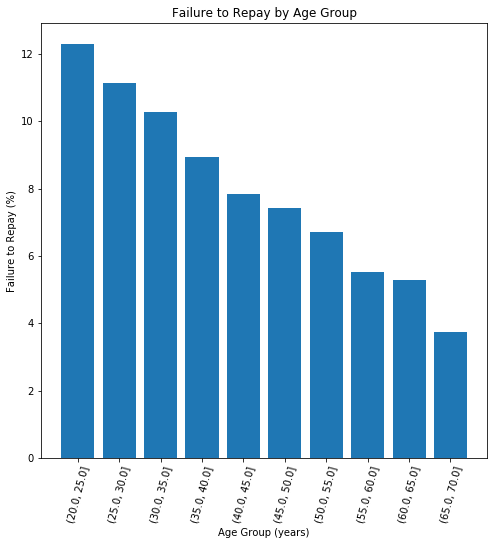

In [26]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')
plt.show()

There is a clear trend: younger applicants are more likely to fail repaying the loan! The rate of failure to repay is above 10% for the youngest three age groups and below 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Effect of days employed on target (applicant has difficulty repay the loan or not)

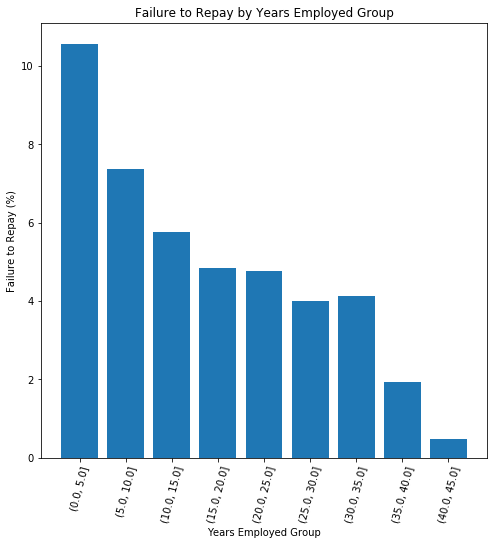

In [47]:
# Days employed information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_EMPLOYED']]
age_data['YEARS_EMPLOYED'] = age_data['DAYS_EMPLOYED'] / 365

# Bin the years employed data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_EMPLOYED'], bins = np.linspace(0, 45, num = 10))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Years Employed Group')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Years Employed Group')
plt.show()

With more years employed at the time of application, applicants have better chance to repay the loan
With years employed over 10-15 years, failure to repay (%) is below 5%

### Effect of credit amount on target (applicant has difficulty repay the loan or not)

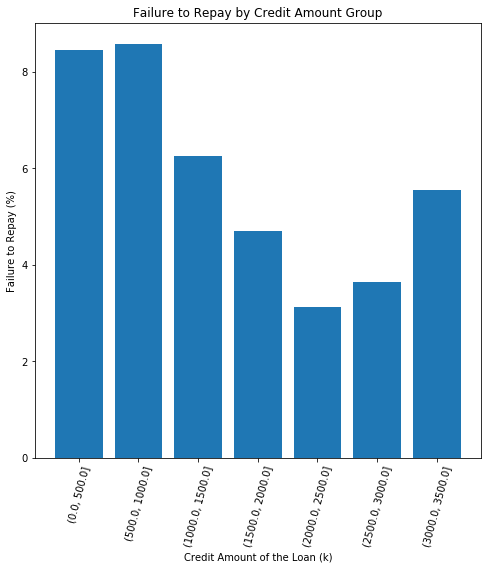

In [50]:
# Credit Amount information into a separate dataframe
age_data = app_train[['TARGET', 'AMT_CREDIT']]

# Bin the credit amount data
age_data['AMT_CREDIT'] = pd.cut(age_data['AMT_CREDIT']/1000, bins = np.linspace(0, 3500, num = 8))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('AMT_CREDIT').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Credit Amount of the Loan (K)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Credit Amount Group')
plt.show()

Overall, larger credit amount of loan has more likely to be repaid
However, loan of credit amount over 2,500K is more likely to be failed repaid

## Further pre-processing

### Get the features and target

In [14]:
X = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']

### Over sampling

In [15]:
# Print the unique value and their number for the target
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [16]:
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler (with random_state=0)
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)

pd.DataFrame(data=y, columns=['TARGET'])['TARGET'].value_counts()

1    282686
0    282686
Name: TARGET, dtype: int64